<a href="https://colab.research.google.com/github/VicLopes/Computer-Intelligence/blob/main/Making_New_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configuração

* Importando bibliotecas


In [ ]:
#Instrumentos para análise de dados
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import itertools
import collections
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 

#Instrumentos para análise de texto
import tweepy as tw
import nltk
from nltk import bigrams
from nltk.corpus import stopwords
import re
import networkx as nx
from textblob import TextBlob

* Chaves e autorização da API do Twitter, utilizado para interagir com a plataforma
* Estas chaves são referentes à conta @feliperubeen

In [ ]:
consumer_key = 'qnP8Cy97bhQT6gdblR8KpVlBm'
consumer_secret = 'pCSejqwTRhTeByxfV8VnjG2j0Fe6R5kgBkDRnepabM9scoqJNI'
access_token = '2180302805-vQFy2XiXA9yPeKYqj5gnBaTjO8Z3iWwyXFQOYi5'
access_token_secret = 'pNmZuHlGxqYDvLOlGbXtIhcv9YFY8LKU6JiT1lAR28j4K'

auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

# Obtenção dos dados
O input insere o termo de busca desejado, removendo-se os retweets. É possível complementar com mais opções, de acordo com a guia do [API do Twitter](https://developer.twitter.com/en/docs/twitter-api/v1/rules-and-filtering/search-operators).

*   Por enquanto, utilizam-se apenas os 1000 primeiros itens obtidos como exemplo
*   Opta-se também pelo uso da linguagem em inglês, visto que as ferramentas de tratamento de texto possuem melhor compatibilidade com esta e a maior parte dos tweets são em inglês
*   A data fim da busca pode ser alterada hardcoded na variável "data_since"

In [ ]:
print("Insira o tema a ser pesquisado:")
search_word = input() 
search_words = search_word+ "-filter:retweets"
date_since = "2019-01-01"

tweets = tw.Cursor(api.search, 
                           q=search_words,
                           lang="en",
                           since=date_since).items(4000)

pd.options.display.max_colwidth = 150

Insira o tema a ser pesquisado:
overwatch


---
# Filtragem dos dados
Como toda rede social, o Twitter possui uma linguagem diferenciada da norma padrão, além de utilizar de maneira constante emojis, links ou similares. Portanto, é necessário tratar os dados para que estes sejam excluídos e não contabilizados na relação.


Para remover URLs, utiliza-se uma função que roda uma regex que irá substituir toda URL por uma string vazia (`""`)

In [ ]:
#  def remove_url(txt):
#    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())
    
def remove_url(txt):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    no_url = url_pattern.sub(r'', txt)

    return no_url

Após estabelecer a função, gera-se o dataset com o texto dos tweets.

In [ ]:
# Remove URLs
tweets_no_urls = [remove_url(tweet.text) for tweet in tweets]

# Create a sublist of lower case words for each tweet
words_in_tweet = [tweet.lower().split() for tweet in tweets_no_urls]

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Remove stop words from each tweet list of words
tweets_nsw = [[word for word in tweet_words if not word in stop_words]
              for tweet_words in words_in_tweet]

# Remove collection words
collection_words = ['climatechange', 'climate', 'change']

tweets_nsw_nc = [[w for w in word if not w in collection_words]
                 for word in tweets_nsw]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Correlação de palavras

In [ ]:
# Create list of lists containing bigrams in tweets
terms_bigram = [list(bigrams(tweet)) for tweet in tweets_nsw_nc]

# View bigrams for the first tweet
terms_bigram[0]

# Original tweet without URLs
tweets_no_urls[0]

# Clean tweet 
tweets_nsw_nc[0]

# Flatten list of bigrams in clean tweets
bigrams = list(itertools.chain(*terms_bigram))

# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigrams)

bigram_counts.most_common(20)

bigram_df = pd.DataFrame(bigram_counts.most_common(20),
                             columns=['bigram', 'count'])

bigram_df

,bigram,count
0,"(play, overwatch)",196
1,"(playing, overwatch)",186
2,"((overwatch:, origins)",97
3,"(origins, edition))",97
4,"(#ps4live, (overwatch:)",96
5,"(edition), live)",94
6,"(check, broadcast)",88
7,"(broadcast, playstation)",87
8,"(playstation, 4!)",87
9,"(4!, #ps4live)",87


In [ ]:
api.update_status()

# Análise dos Sentimentos
Os objetos do Sentimento

In [ ]:
sentiment_objects = [TextBlob(tweet) for tweet in tweets_no_urls]

sentiment_objects[0].polarity, sentiment_objects[:5]

(-0.7142857142857143,
 [TextBlob("@arcanemagi i got sick of moicy 6 months into overwatch 💀💀💀 im sick of moira being mercy’s dyke and nothing else. t… "),
  TextBlob("Overwatch Uncovered by Overwolf XD "),
  TextBlob("🔸BENKEIS! now streaming on Twitch! Playing 
  #twitch
  
  Overwatch  "),
  TextBlob("me remembering how i conditioned my voice to sound deeper and raspier on overwatch voice coms so i wouldnt be haras… "),
  TextBlob("#MatteoHS is now streaming #Overwatch ")])

Valores de sentimento

In [ ]:
sentiment_values = [[tweet.sentiment.polarity, str(tweet)] for tweet in sentiment_objects]

sentiment_values[:5]

[[-0.7142857142857143,
  '@arcanemagi i got sick of moicy 6 months into overwatch 💀💀💀 im sick of moira being mercy’s dyke and nothing else. t… '],
 [0.0, 'Overwatch Uncovered by Overwolf XD '],
 [0.0, '🔸BENKEIS! now streaming on Twitch! Playing \n#twitch\n\nOverwatch  '],
 [0.4,
  'me remembering how i conditioned my voice to sound deeper and raspier on overwatch voice coms so i wouldnt be haras… '],
 [0.0, '#MatteoHS is now streaming #Overwatch ']]

In [ ]:
sentiment_df = pd.DataFrame(sentiment_values, columns=["polarity", "tweet"])

sentiment_df.head()

,polarity,tweet
0,-0.714286,@arcanemagi i got sick of moicy 6 months into overwatch 💀💀💀 im sick of moira being mercy’s dyke and nothing else. t…
1,0.000000,Overwatch Uncovered by Overwolf XD
2,0.000000,🔸BENKEIS! now streaming on Twitch! Playing \n#twitch\n\nOverwatch
3,0.400000,me remembering how i conditioned my voice to sound deeper and raspier on overwatch voice coms so i wouldnt be haras…
4,0.000000,#MatteoHS is now streaming #Overwatch


# Exposição de dados do Sentimento

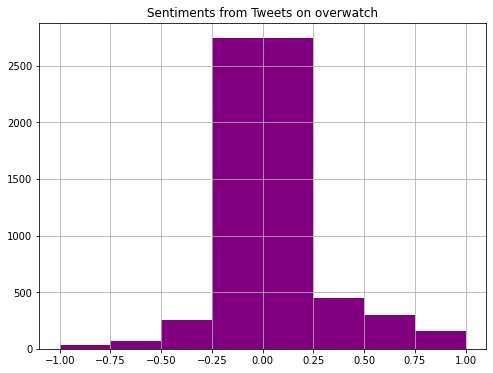

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram of the polarity values
sentiment_df.hist(bins=[-1, -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1],
             ax=ax,
             color="purple")

plt.title("Sentiments from Tweets on "+search_words[:-16])
plt.show()

Porém, precisamos remover aqueles que possuem sentimento de 0, e criamos um histograma com uma 'quebra' no 0.

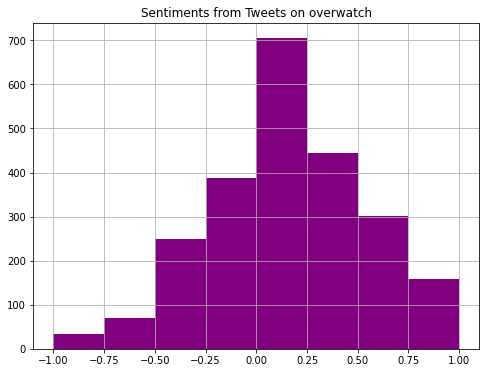

In [ ]:
sentiment_df = sentiment_df[sentiment_df.polarity != 0]

fig, ax = plt.subplots(figsize=(8, 6))

sentiment_df.hist(bins=[-1, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1],
             ax=ax,
             color="purple")

plt.title("Sentiments from Tweets on "+search_words[:-16])
plt.show()


Agora, tendo o histograma em mãos, podemos classificar os dados dos sentimentos. Para este, dividimos que aqueles entre -1,1 e 0 são iguais a 0, ou seja, são negativos, e aqueles entre 0 e 1,1 são iguais a 1, ou seja, positivos.

In [ ]:
bins = [-1.1, 0, 1.1]
label_names = [0, 1]

sentiment_df['positive'] = pd.cut(sentiment_df['polarity'], bins, labels=label_names)
sentiment_df.head()

,polarity,tweet,positive
0,-0.714286,@arcanemagi i got sick of moicy 6 months into overwatch 💀💀💀 im sick of moira being mercy’s dyke and nothing else. t…,0
3,0.400000,me remembering how i conditioned my voice to sound deeper and raspier on overwatch voice coms so i wouldnt be haras…,1
7,0.144167,@vsobudula @ntsikimazwai Very true my sister. The system has created conditions for black men and women to be at lo…,1
9,0.068182,"New Overwatch character idea, Domefist, his ULT is that every female character in the vicinity has to give him dome",1
10,0.160000,"@authenticnoob05 @Freakygamerfan_ That says Sky High. Y’know, the Overwatch song?",1


#Configuração da IA
Agora, configuramos a IA. Para tal, utilizaremos o Tokenizer para tokenizar as palavras, e classificá-las para gerar a nossa IA.

In [ ]:
tokenizer = Tokenizer()
tweet_list = sentiment_df['tweet'].astype('str').tolist()
tokenizer.fit_on_texts(tweet_list)

total_words = len(tokenizer.word_index) + 1
total_words

6212

Sequências de input utilizando a lista de tokens

In [ ]:
input_sequences = []
for tweet in tweet_list:
 token_list = tokenizer.texts_to_sequences([tweet])[0]
 for i in range(1, len(token_list)):
  n_gram_sequence = token_list[:i+1]
  input_sequences.append(n_gram_sequence)

In [ ]:
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

Cria-se o previsor de palavras. Nesse caso, utiliza-se um LSTM (Long Short-term Memory), visto que este acaba por considerar a frase inteira que já foi obtida no seu resultado.

In [ ]:
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
label = ku.to_categorical(label, num_classes=total_words)

model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 29, 100)           621200    
_________________________________________________________________
bidirectional (Bidirectional (None, 29, 300)           301200    
_________________________________________________________________
dropout (Dropout)            (None, 29, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 3106)              313706    
_________________________________________________________________
dense_1 (Dense)              (None, 6212)              19300684  
Total params: 20,697,190
Trainable params: 20,697,190
Non-trainable params: 0
____________________________________________

In [ ]:
history = model.fit(predictors, label, epochs=50, verbose=1)

Epoch 1/50
1072/1072 [==============================] - 358s 334ms/step - loss: 6.3213 - accuracy: 0.0708
Epoch 2/50
1072/1072 [==============================] - 358s 334ms/step - loss: 6.1524 - accuracy: 0.0908
Epoch 3/50
1072/1072 [==============================] - 353s 329ms/step - loss: 6.0214 - accuracy: 0.0994
Epoch 4/50
1072/1072 [==============================] - 340s 317ms/step - loss: 5.9065 - accuracy: 0.1081
Epoch 5/50
1072/1072 [==============================] - 331s 309ms/step - loss: 5.8086 - accuracy: 0.1133
Epoch 6/50
1072/1072 [==============================] - 329s 307ms/step - loss: 5.7118 - accuracy: 0.1200
Epoch 7/50
1072/1072 [==============================] - 329s 307ms/step - loss: 5.6228 - accuracy: 0.1267
Epoch 8/50
1072/1072 [==============================] - 336s 313ms/step - loss: 5.5349 - accuracy: 0.1324
Epoch 9/50
1072/1072 [==============================] - 341s 319ms/step - loss: 5.4520 - accuracy: 0.1382
Epoch 10/50
1072/1072 [=======================

# Resultado
Aqui, por último, encontra-se o gerador de texto. Para isto, ele faz uma previsão de palavra-por-palavra para decidir o que será a próxima palavra baseado nos dados obtidos do twitter.

In [ ]:
seed_text = input("Escolha a seed to tweet a ser gerado: ")
next_words = np.random.randint(20)
print(str(next_words+1)+" palavras")
  
for _ in range(next_words):
 token_list = tokenizer.texts_to_sequences([seed_text])[0]
 token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
 predicted = np.argmax(model.predict(token_list), axis=-1)
 output_word = ""
 for word, index in tokenizer.word_index.items():
  if index == predicted:
   output_word = word
   break
 seed_text += " " + output_word
print(seed_text)

Escolha a seed to tweet a ser gerado: overwatch
2 palavras
overwatch is


In [ ]:
while True:pass